In [1]:
cd '/home/antoine/Documents/owndev/fistwriter_project/'

/home/antoine/Documents/owndev/fistwriter_project


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)

import h5py
import numpy as np

import time
import itertools

from sys import path
path.insert(1,'/home/antoine/Documents/owndev/fistwriter_project/sqlexperiment')
import experimentlog
import extract

In [3]:
from os import path

logFilename = '/home/antoine/Documents/data/0/0.db'

with experimentlog.ExperimentLog(logFilename, ntp_sync=False) as exp:
    sessions = extract.dump_sessions_dataframe(exp.cursor)
    flatdf = extract.dump_flat_dataframe(exp.cursor)
    meta = extract.meta_dataframe(exp.cursor)

metasession = meta['SESSION']
expruns = metasession[metasession['type'] == 'exprun']
touchdf = flatdf['touch']

In [4]:
expruns

bound                                               data description  \
1   [2]  {u'hdf5': u'/home/antoine/Documents/data/0/NAV...               
2   [3]  {u'hdf5': u'/home/antoine/Documents/data/0/MOZ...               
3   [4]  {u'hdf5': u'/home/antoine/Documents/data/0/VAC...               

                              name    type  
1  NAVEL-APECA_2016-12-23_19:16:04  exprun  
2  MOZAD-IFELI_2016-12-23_19:16:50  exprun  
3  VACEL-EKOSU_2017-01-04_18:29:40  exprun

In [5]:
def print_attrs(name, obj):
    print name
    for key, val in obj.attrs.iteritems():
        print "    %s: %s" % (key, val)

In [6]:
from IPython import embed
embed()

Python 2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
Type "copyright", "credits" or "license" for more information.

IPython 5.1.0 -- An enhanced Interactive Python.
?         -> Introduction and overview of IPython's features.
%quickref -> Quick reference.
help      -> Python's own help system.
object?   -> Details about 'object', use 'object??' for extra details.

In [1]: q
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<ipython-input-1-c3be117041a1> in <module>()
----> 1 q

NameError: name 'q' is not defined

In [2]: exit



# Get the data

we need to define a structure that holds the different streams of data together, namely the video data and the touch data.



In [7]:
class Dataset(object):
    def __init__(self, X, org, mat):
        self.X = X
        self.org = org
        self.mat = mat

X = []
y = []

for ids in expruns.index:
    boundsession = expruns.loc[ids].bound[0]
    print boundsession
    ## X
    filename = expruns.loc[ids]['data']['hdf5']
    hdf5file = h5py.File(filename, 'r')
    x = hdf5file[str(boundsession)]['depth']
    org = hdf5file['origin']
    mat = hdf5file['matrix']
    ## y
    _y = np.array(touchdf[touchdf['session'] == boundsession][['x', 'y']])
    _y = np.c_[_y, (_y != (-1, -1)).all(1)]

    ## dataset
    X.append(Dataset(x, org, mat))
    y.append(_y)


2
3
4


In [8]:
# # TEST

# testpip = pipeline.Pipeline([
#     ('step1', ml.Step1()),
# #     ('roiextractor', ml.RoiExtractor()),
# #     ('fingerPlaneExtractor', ml.FingerPlaneExtractor()),
# #     ('classfeatureextractor', ml.ClassFeatureExtractor()),
# ])

# X_feature = testpip.transform(X_test)

# np.argwhere(y_test)[:50]

# for i in range(46):
#     X = X_feature.next()

# from pyrealsense import offline
# offline.load_depth_intrinsics('610205001689')

# g = X_test[0]
# d = g.X[70]
# pc = offline.deproject_depth(d)
# pc_ = np.dot(g.mat, (pc - g.org).reshape((-1,3)).T).T

# def _filter(pc):
#     xm = pc[:,0] >= -0.1
#     xp = pc[:,0] <= 1.1
#     ym = pc[:,1] >= -0.1
#     yp = pc[:,1] <= 1.1
#     return pc[xm & xp & ym & yp]

# pc__ = _filter(pc_)

# plot_objects(pc)

# plot_objects(pc__, axis=True)

# roie = ml.RoiExtractor()

# roie.transform(pc__)

# g.X[70, :, :]

# X_test

# Compute the features

In [9]:
from sklearn import pipeline
from sklearn import metrics
from sklearn import svm

from fistwriter import ml
from fistwriter.utils import plot_objects

ml = reload(ml)

classpip = pipeline.Pipeline([
    ('step1', ml.Step1()),
    ('pointcloudshaper', ml.PointcloudShaper()),
    ('roiextractor', ml.RoiExtractor()),
    ('fingerPlaneExtractor', ml.FingerPlaneExtractor()),
    ('classfeatureextractor', ml.ClassFeatureExtractor()),
])

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN not available)


In [10]:
train_id, test_id = [0,2], [1]

In [11]:
X_train, X_test = [X[i] for i in train_id], [X[i] for i in test_id]
X_train_feature = classpip.transform(X_train)
X_test_feature = classpip.transform(X_test)

In [12]:
y_test, y_train = [y[i] for i in test_id], [y[i] for i in train_id]
y_test = np.concatenate(y_test)
y_train = np.concatenate(y_train)

In [13]:
X_test_feature.shape

(900, 99)

# compute ROI stage performance

this make sure that the ROI stage is not throwing away frames which are touching

In [14]:
## check all roi are non-touch
print (y0[X_feat_touchclass_zeros_id][:,2] == 0).all()
y_roi_pred = ~X_feat_touchclass_zeros_id

NameError: name 'y0' is not defined

In [15]:
print metrics.classification_report(y0[:,2], y_roi_pred)
print(metrics.confusion_matrix(y0[:,2], y_roi_pred))

NameError: name 'y0' is not defined

# print features

In [16]:
y_train_ = y_train[:,2]
y_test_ = y_test[:,2]
true_frame = np.random.choice(np.argwhere(y_train_ == True).reshape(-1), size=10)
false_frame = np.random.choice(np.argwhere(y_train_ == False).reshape(-1), size=10)

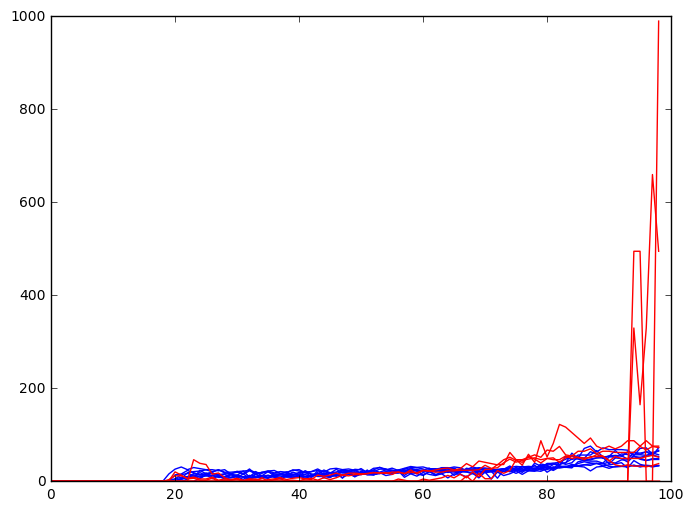

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

for x in true_frame:
    ax.plot(X_train_feature[x], 'b')
for x in false_frame:
    ax.plot(X_train_feature[x], 'r')

In [18]:
fig.savefig('features.pdf')

# use SVM

In [19]:
clf = svm.SVC()
clf.fit(X_train_feature, y_train_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
y_pred = clf.predict(X_test_feature)

print metrics.classification_report(y_test_, y_pred)
print(metrics.confusion_matrix(y_test_, y_pred))

             precision    recall  f1-score   support

        0.0       0.54      1.00      0.70       489
        1.0       0.00      0.00      0.00       411

avg / total       0.30      0.54      0.38       900

[[489   0]
 [411   0]]


/home/antoine/anaconda3/envs/fistwriter_py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# use MLP

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(64, input_dim=99, init='uniform', activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [22]:
history = model.fit(X_train_feature, y_train[:,2], validation_split=0.1, nb_epoch=150, batch_size=300)
score = model.evaluate(X_test_feature, y_test[:,2], batch_size=16)

Train on 1620 samples, validate on 180 samples
Epoch 1/150
1620/1620 [==============================] - 0s - loss: 3.4444 - acc: 0.6340 - val_loss: 1.2669 - val_acc: 0.82221200/1620 [=====================>........] - ETA: 0s - loss: 3.9401 - acc: 0.5992
Epoch 2/150
1620/1620 [==============================] - 0s - loss: 1.2970 - acc: 0.8154 - val_loss: 0.7796 - val_acc: 0.9222
Epoch 3/150
1620/1620 [==============================] - 0s - loss: 0.8684 - acc: 0.8315 - val_loss: 0.3895 - val_acc: 0.9778
Epoch 4/150
1620/1620 [==============================] - 0s - loss: 0.4384 - acc: 0.8926 - val_loss: 0.3

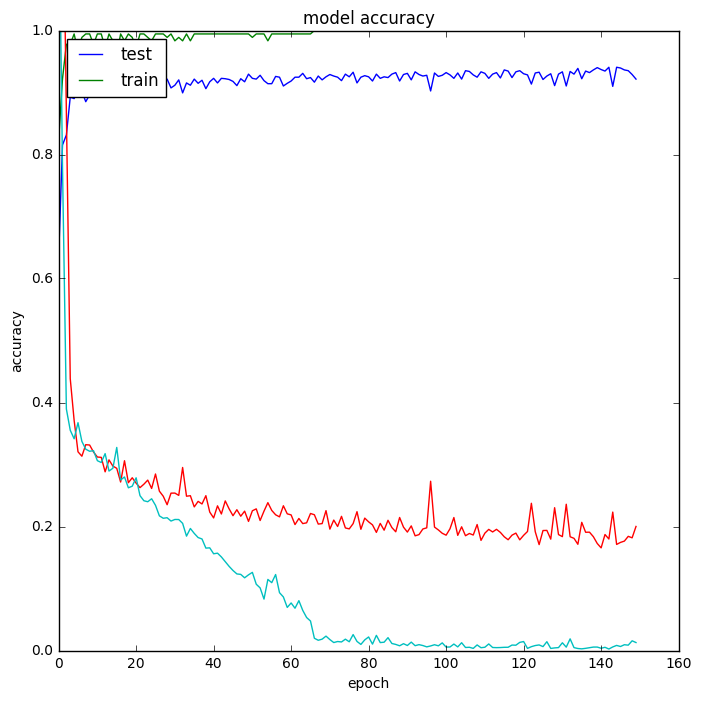

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
# summarize history for accuracy
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('model accuracy')
ax.set_ylim([0,1])
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['test', 'train'], loc='upper left')
# ax.show()
# summarize history for loss
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
# ax.ylim([0,5])
# ax.title('model loss')
# ax.ylabel('loss')
# ax.xlabel('epoch')
ax.legend(['test', 'train'], loc='upper left')
# ax.show()
fig.savefig('mlp')

In [33]:
print score

[0.49632096375856133, 0.93888888888888888]


In [34]:
y_pred = model.predict(X_test_feature)
print metrics.classification_report(y_test[:,2], np.round(y_pred))
print(metrics.confusion_matrix(y_test[:,2], np.round(y_pred)))

             precision    recall  f1-score   support

        0.0       0.95      0.93      0.94       489
        1.0       0.92      0.94      0.93       411

avg / total       0.94      0.94      0.94       900

[[457  32]
 [ 23 388]]


# save the model to pickled file

In [ ]:
import datetime
datetime_format = "%Y-%m-%d_%H:%M:%S"
print datetime.datetime.now().strftime(datetime_format)

In [ ]:
dataPath = '/home/antoine/Documents/data/0/'
now = datetime.datetime.now().strftime(datetime_format)
model.save(dataPath+'model_touch_'+now+'.hdf5')

# plot the ROI curve

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_, y_pred)
roc_auc = metrics.auc(fpr, tpr)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

for i in np.arange(0, thresholds.shape[0], 10):
    x,y = (fpr[i], tpr[i])
    ax.scatter(x,y)
    ax.annotate(str(thresholds[i]), xy=(x,y))

# for k, (x,y) in letters_dict.items():
#     (x,y) = np.array((x,y)) * tablet_size
#     ax.annotate(k, xy=(x,y), xytext=(x+1,y-0.3))
#     ax.plot(x, y, 'r+', markersize=10)


In [ ]:
fig.savefig('roc.pdf')

In [ ]:
np.arange(0, thresholds.shape[0], 10)

# Look at misclassified frames

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_test[:,2])
ax.plot(np.round(y_pred))
ax.set_ylim([-1,2])

In [ ]:
y_pred_round = np.round(y_pred).reshape(-1)
y_test_ = y_test[:,2]
miss = np.argwhere(y_pred_round != y_test_)

In [ ]:
miss

In [ ]:
plt.plot(X_test_feature[75])
plt.plot(X_test_feature[76])
plt.plot(X_test_feature[508])

In [ ]:
cnt = 0 
for i in miss:
    if (X_test_feature[i] == 0).all(): cnt += 1

In [ ]:
_y = np.array(touchdf[touchdf['session'] == 3][['x', 'y', 't']])
_y = np.c_[(_y[:,:2] != (-1, -1)).all(1), _y, np.r_[0, np.diff(_y[:,-1])]]

In [ ]:
np.save('touch_trace', _y)